In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

C:\Users\cros4\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


            #guests
time               
2012-01-01      238
2012-02-01      129
2012-03-01      110
2012-04-01      230
2012-05-01      158
DatetimeIndex(['2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
        

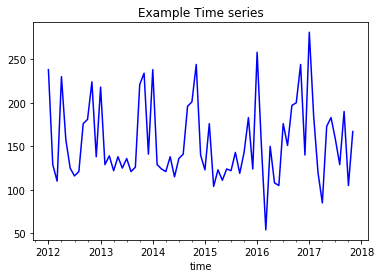

time
2012-01-01    238
2012-02-01    129
2012-03-01    110
2012-04-01    230
2012-05-01    158
2012-06-01    125
2012-07-01    116
2012-08-01    121
2012-09-01    176
2012-10-01    181
Name: #guests, dtype: int64

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('./data/hotelguests.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)
print(data.head())
print(data.index)
ts = data['#guests']
ts.plot(c='b', title='Example Time series')
plt.show()
ts.head(10)

In [3]:
TS = np.array(ts)
num_periods = 12
f_horizon = 1
x_data = TS[:(len(TS)-(len(TS)% num_periods))]
x_batches = x_data.reshape(-1, 12, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 12, 1)
print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

5
(5, 12, 1)
[[[238]
  [129]
  [110]
  [230]
  [158]
  [125]
  [116]
  [121]
  [176]
  [181]
  [224]
  [138]]

 [[218]
  [129]
  [139]
  [122]
  [138]
  [125]
  [136]
  [121]
  [126]
  [221]
  [234]
  [141]]]
[[[129]
  [110]
  [230]
  [158]
  [125]
  [116]
  [121]
  [176]
  [181]
  [224]
  [138]
  [218]]]
(5, 12, 1)


In [4]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 12, 1)
    testY = TS[-(num_periods):].reshape(-1, 12, 1)
    return testX,testY
X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 12, 1)
[[[244]
  [140]
  [281]
  [185]
  [120]
  [ 85]
  [173]
  [183]
  [158]
  [129]
  [190]
  [105]]]


In [10]:
tf.reset_default_graph()

num_periods = 12
inputs = 1
hidden = 200
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
#BasicRNNCell
#BasicLSTMCell
learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [20]:
epochs = 5000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 1623610.1
100 	MSE: 132474.72
200 	MSE: 89955.51
300 	MSE: 35394.24
400 	MSE: 67153.52
500 	MSE: 58643.07
600 	MSE: 52434.754
700 	MSE: 56180.48
800 	MSE: 41090.2
900 	MSE: 27120.52
1000 	MSE: 233842.47
1100 	MSE: 26308.906
1200 	MSE: 22368.676
1300 	MSE: 35473.53
1400 	MSE: 78941.36
1500 	MSE: 64169.06
1600 	MSE: 53595.67
1700 	MSE: 41171.84
1800 	MSE: 23690.129
1900 	MSE: 28203.223
2000 	MSE: 24581.715
2100 	MSE: 20345.37
2200 	MSE: 18215.785
2300 	MSE: 24358.883
2400 	MSE: 16494.002
2500 	MSE: 10885.537
2600 	MSE: 8807.386
2700 	MSE: 7612.899
2800 	MSE: 6343.341
2900 	MSE: 10901.546
3000 	MSE: 6597.5664
3100 	MSE: 4709.605
3200 	MSE: 3766.8289
3300 	MSE: 2290.2864
3400 	MSE: 39013.938
3500 	MSE: 23473.725
3600 	MSE: 12453.68
3700 	MSE: 17343.184
3800 	MSE: 6893.717
3900 	MSE: 14144.703
4000 	MSE: 22705.61
4100 	MSE: 18872.844
4200 	MSE: 10690.672
4300 	MSE: 13424.125
4400 	MSE: 12212.307
4500 	MSE: 11587.888
4600 	MSE: 11042.652
4700 	MSE: 10464.197
4800 	MSE: 9956.043
4900 

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100, np.mean(np.abs((y_true - y_pred) / y_true))

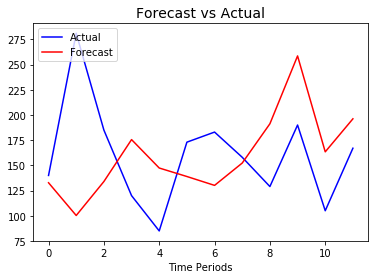

TEST
[[[140]
  [281]
  [185]
  [120]
  [ 85]
  [173]
  [183]
  [158]
  [129]
  [190]
  [105]
  [167]]]
PRED
[[[132.76048]
  [100.29158]
  [133.9637 ]
  [175.55003]
  [147.37291]
  [138.9484 ]
  [130.1511 ]
  [152.30658]
  [191.2344 ]
  [258.51694]
  [163.40344]
  [196.15213]]]


In [22]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'b', markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), 'r', markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()
print('TEST')
print(Y_test)
print('PRED')
print(y_pred)

In [23]:
MAPE, MAD = mean_absolute_percentage_error(Y_test,y_pred)
print("MAPE : {}".format(MAPE))
print("MAD : {}".format(MAD))

MAPE : 35.52404117422885
MAD : 0.3552404117422885
